# EDA and Visualization Final Project: Data Prep and Analysis
## Zachary Barnes and Bing Wang

##### Housekeeping

In [1]:
# Load Python libraries
import os
import numpy as np
import pandas as pd

# Run R code adjacent to Python code
%load_ext rpy2.ipython

# Load ggplot R library
%R library(ggplot2)
%R library(scales)

# Avoid kernal death
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Read in and organize data (Collisions and Victims datasets, from TIMS)

In [2]:
c = pd.read_csv("Collisions.csv")

# Keep only relevant columns
# c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
#         'LIGHTING','LOCATION_TYPE','MVIW','TYPE_OF_COLLISION',
#         'WEATHER_1','LATITUDE','LONGITUDE','PRIMARY_RD',
#         'SECONDARY_RD','POINT_X','POINT_Y']]





# EDIT 10/2: CHANGED COLUMNS A BIT!!
c = c[['CASE_ID','COLLISION_DATE','COLLISION_TIME','INTERSECTION','COLLISION_SEVERITY',
       'LIGHTING','LOCATION_TYPE', 'ROAD_SURFACE', 'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT',
       'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'ALCOHOL_INVOLVED',
       'LATITUDE','LONGITUDE','PRIMARY_RD','SECONDARY_RD','POINT_X','POINT_Y']]




# Convert COLLISION_TIME to hour of day (use tlater to match speeds to collisions)
c['COLLISION_TIME'] = [int(i[:-2]) if len(i) > 2 else 0 for i in c['COLLISION_TIME'].astype(str).values]

# Make Collision_Date a DateTime object
c["COLLISION_DATE"] = pd.to_datetime(c.COLLISION_DATE)

# Add quarter column (use later in match speeds to collisions)
c['QUARTER'] = c['COLLISION_DATE'].map(pd.to_datetime).dt.quarter

print(len(c))
c.sample(5)

3870


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,MOTORCYCLE_ACCIDENT,TRUCK_ACCIDENT,ALCOHOL_INVOLVED,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER
2934,8575258,2018-02-03,23,N,3,C,NaN,A,H,Y,...,NaN,NaN,NaN,NaN,NaN,6TH ST,NATOMA ST,-122.407706,37.780209,1
1108,8727536,2018-12-24,5,Y,4,C,H,B,H,NaN,...,NaN,NaN,Y,NaN,NaN,JUNIPERO SERRA BL,19TH AV,-122.472366,37.716699,4
1068,8745167,2018-10-29,12,N,4,A,NaN,A,H,NaN,...,NaN,NaN,NaN,NaN,NaN,TARAVAL ST,WAWONA ST,-122.465739,37.743582,4
3792,90877185,2018-11-27,14,N,4,A,NaN,B,H,NaN,...,NaN,NaN,NaN,37.80509,-122.36993,I-80 E/B,YERBA BUENA ISLAND TUNNEL (WEST EDGE),-122.370147,37.805328,4
1744,8683817,2018-07-06,1,N,4,C,NaN,A,H,Y,...,NaN,NaN,Y,NaN,NaN,3RD ST,MISSION ST,-122.401231,37.785634,3


In [3]:
v = pd.read_csv('Victims.csv')

# Keep only relevant columns
v = v[['CASE_ID','VICTIM_DEGREE_OF_INJURY','VICTIM_ROLE','VICTIM_AGE']]

# Keep only fatalities and severe injuries (Victim_Degree_of_Injury = 1 or 2)
v = v.loc[v.VICTIM_DEGREE_OF_INJURY.isin([1, 2])]

print(len(v))
v.sample(5)

289


,CASE_ID,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
23,8796720,2,1,30
4994,8465594,1,3,34
4988,8465901,1,3,57
3722,8603037,2,2,25
453,8766620,2,4,59


In [4]:
# Merge Collisions and Victims datasets
cv = pd.merge(c, v, how='left', on='CASE_ID')

print(len(cv))
print(cv.COLLISION_SEVERITY.value_counts())
print(cv.VICTIM_DEGREE_OF_INJURY.value_counts())
cv.head()

len(cv.loc[~(cv.VICTIM_DEGREE_OF_INJURY.isna())])

3882
4    2549
3    1014
2     294
1      25
Name: COLLISION_SEVERITY, dtype: int64
2.0    262
1.0     25
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64


287

In [5]:
# Paul's Function to remove NaNs from columns
def fixDFcolsForR(myDF):
    for i in range(myDF.shape[1]): # for each col
        if myDF.iloc[:, i].dtype == 'O': # check if col is type object
            myDF.iloc[:, i] = myDF.iloc[:, i].astype(str) # if yes set type to string
    return myDF

In [6]:
# Convert NaNs to string type
cv = fixDFcolsForR(cv)
cv.sample(5)

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,LATITUDE,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE
1399,8704033,2018-07-23,13,Y,4,A,nan,A,H,Y,...,NaN,NaN,FOLSOM ST,5TH ST,-122.403400,37.780270,3,NaN,NaN,NaN
2199,8637010,2018-05-19,17,N,4,A,nan,A,H,nan,...,NaN,NaN,GEARY BL,27TH AV,-122.486890,37.780050,2,NaN,NaN,NaN
1412,8699985,2018-08-16,17,Y,4,A,nan,A,H,nan,...,NaN,NaN,COLUMBUS ST,CHESTNUT ST,-122.414880,37.803550,3,NaN,NaN,NaN
300,8777412,2018-12-10,13,N,4,A,nan,A,H,nan,...,NaN,NaN,MARKET ST,NOE ST,-122.433649,37.763876,4,NaN,NaN,NaN
1183,8716569,2018-09-29,6,N,4,A,nan,A,H,nan,...,NaN,NaN,TAYLOR ST,CLAY ST,-122.412894,37.793757,3,NaN,NaN,NaN


Now, we need to attach Open Street Maps (OSM) way IDs to each observation in the Collisions-Victims dataset, in order to match with the speed dataset. An OSM way ID is an ID that matches latitude and longitude to a street segment.

# Use Nominatim API to convert lat long to OSM ID

In [7]:
# import requests
# import json

# def osmid(lat,lon):
#     URL = 'https://nominatim.openstreetmap.org/reverse?format=json&lat=%s&lon=%s'
#     r = requests.get(URL % (lat,lon))
#     data = json.loads(r.text)
# #     osm_id = data.get('osm_id','NONE')
#     return data['osm_id']


This code snippet below creates osm.csv, a list of OSM IDS and their latitudes and longitudes. We will use this to attach OSM IDs to our Collisions-Victims dataset.

In [8]:
# import time
# lat_long = cv[['POINT_Y','POINT_X','VICTIM_DEGREE_OF_INJURY']]
# osm_id = list()
# for i,row in lat_long.iterrows():
#     if (np.isnan(row['POINT_Y']) or np.isnan(row['POINT_X'])) or np.isnan(row['VICTIM_DEGREE_OF_INJURY']):
#         osm_id.append('NONE')
#         continue
#     else:
#         time.sleep(2)
#         osm_id.append(osmid(row['POINT_Y'],row['POINT_X']))
# osm_series = pd.Series(osm_id)
# osm_series.to_csv('osm.csv')

# Add OSM_ID column 

In [9]:
# since we have preprocessed and saved OSM ID data, just read in as csv
osm = pd.read_csv('osm.csv',header=None)
osm.columns = ['index','OSM_ID']
cv['OSM_ID'] = osm['OSM_ID']

print(len(cv))
print(len(osm))
cv.loc[~(cv.VICTIM_DEGREE_OF_INJURY.isna())].sample(5)

3882
3882


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,LONGITUDE,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,OSM_ID
1860,8667490,2018-06-14,16,Y,2,A,nan,A,H,Y,...,NaN,MARTIN LUTHER KING JR DR,9TH AV,-122.466440,37.766380,2,2.0,3.0,54.0,397169005
3239,8553201,2018-01-14,22,N,2,C,nan,A,H,nan,...,NaN,OCTAVIA ST,HAIGHT ST,-122.423873,37.772689,1,2.0,1.0,38.0,415307827
2940,8575270,2018-02-14,13,Y,2,A,nan,A,H,nan,...,NaN,BAY ST,MIDWAY ST,-122.409480,37.806140,1,2.0,1.0,42.0,1083221110
1281,8716462,2018-09-24,19,N,2,C,nan,A,H,Y,...,NaN,BROADWAY ST,COLUMBUS AV,-122.406383,37.797921,3,2.0,3.0,73.0,5581481079
981,8754734,2018-10-07,1,Y,2,C,nan,A,H,nan,...,NaN,3RD ST,OAKDALE AV,-122.390770,37.734830,4,2.0,4.0,33.0,1241690519


# Load in Uber Speeds dataset

Load avgspeeds.csv, the Uber Speeds dataset, and reduce down to speeds.csv (see comment below code)

In [10]:
# avgspeeds = pd.read_csv('avgspeeds.csv')
# avgspeeds.head()

In [11]:
# speeds = list()
# for i, row in cvsmall.iterrows():
#     speed = avgspeeds.loc[(avgspeeds['osm_way_id'] == row['OSM_ID']) & 
#               (avgspeeds['quarter'] == row['QUARTER']) & 
#               (avgspeeds['hour_of_day'] == row['COLLISION_TIME'])]['speed_mph_mean']
#     if speed.values.size > 0:
#          speeds.append(speed.values[0])
        
#     else:
#         speeds.append(0)
# speeds = pd.Series(speeds)
# speeds.to_csv('speeds.csv')


In [12]:
# Reduce cv DataFrame to only entries with non-null Quarter, Collision_Time, and OSM_ID 
# before joining to avgspeeds
cvsmall = cv.loc[(~cv['QUARTER'].isna()) & (~cv['COLLISION_TIME'].isna()) & ~(cv['OSM_ID'] == 'NONE')]
#cvsmall['OSM_ID'] = cvsmall['OSM_ID'].astype(int)

# NOTE 10/1: Commented out as this resulting in error "AttributeError: 'int' object has no attribute 'encode'"

# There are 271 entries.
len(cv.loc[~(cv['OSM_ID'] == 'NONE')])

271

The code below produces speeds.csv, a subset of averagespeeds.csv. It reduces the speeds observations down to ones that would match the Collisions-Victims dataset on OSD_ID, Quarter, and Collision_Time. If there is no match, set speed = 0.

Now, we join cvsmall (the reduced Collisions-Victims dataset) to the speeds dataset.

In [13]:
speeds = pd.read_csv("speeds.csv",header=None)

cvsmall["SPEEDS"] = speeds[1].to_list()
cvsmall.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,PRIMARY_RD,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,OSM_ID,SPEEDS
251,8804185,2018-12-29,18,Y,2,C,nan,A,H,nan,...,PORTOLA DR,CLIPPER ST,-122.444840,37.746940,4,2.0,1.0,32.0,148313526,7.753
254,8796720,2018-12-10,13,N,2,A,nan,A,H,nan,...,SANSOME ST,CHESTNUT ST,-122.403498,37.805128,4,2.0,1.0,30.0,2503369217,0.000
260,8796604,2018-12-28,18,N,2,C,nan,A,H,nan,...,BALBOA ST,4TH AV,-122.462364,37.777302,4,2.0,1.0,39.0,3802986672,0.000
261,8796085,2018-12-11,15,N,2,A,nan,A,H,nan,...,BRYANT ST,4TH ST,-122.397722,37.779838,4,2.0,1.0,45.0,467150002,0.000
266,8787863,2018-12-12,9,N,2,A,nan,A,H,Y,...,HICKORY ST,BUCHANAN ST,-122.428359,37.774759,4,2.0,2.0,998.0,27553863,0.000


Drop accidents on highways (not covered by Vision Zero SF)

In [14]:
cvsmall = cvsmall.loc[cvsmall.LOCATION_TYPE != "H"]
len(cvsmall)

266

# Preliminary graphs (without speed or regressions)

In [15]:
# fix NaNs with Paul's function before passing to R
cvsmall = fixDFcolsForR(cvsmall)

In [16]:
cvsmall.dtypes

CASE_ID                             int64
COLLISION_DATE             datetime64[ns]
COLLISION_TIME                      int64
INTERSECTION                       object
COLLISION_SEVERITY                  int64
LIGHTING                           object
LOCATION_TYPE                      object
ROAD_SURFACE                       object
ROAD_COND_1                        object
PEDESTRIAN_ACCIDENT                object
BICYCLE_ACCIDENT                   object
MOTORCYCLE_ACCIDENT                object
TRUCK_ACCIDENT                     object
ALCOHOL_INVOLVED                   object
LATITUDE                          float64
LONGITUDE                         float64
PRIMARY_RD                         object
SECONDARY_RD                       object
POINT_X                           float64
POINT_Y                           float64
QUARTER                             int64
VICTIM_DEGREE_OF_INJURY           float64
VICTIM_ROLE                       float64
VICTIM_AGE                        

In [17]:
# Add column of months for graphing time series
cvsmall["Month"] = cvsmall.COLLISION_DATE.dt.month

len(cvsmall)

# Aggregate up to month
cvsmall_m = cvsmall.groupby(["VICTIM_DEGREE_OF_INJURY", "Month"]).count().reset_index()

In [18]:
cvs = cvsmall.loc[cvsmall.SPEEDS != 0]
cvs.head()
print(cvs.VICTIM_DEGREE_OF_INJURY.value_counts())
len(cvs)

2.0    94
1.0     7
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64


101

# Chart 1: Time Series line graph of incidences of accidents
(maybe try: cumulative?)

In [19]:
print(cvs.VICTIM_AGE.value_counts())
cvs.VICTIM_DEGREE_OF_INJURY.value_counts()

37.0     6
22.0     5
29.0     5
54.0     5
34.0     4
33.0     4
38.0     4
31.0     3
20.0     3
40.0     3
59.0     3
32.0     3
35.0     3
50.0     3
24.0     2
67.0     2
47.0     2
69.0     2
26.0     2
18.0     2
30.0     2
23.0     2
62.0     2
998.0    2
49.0     2
52.0     2
42.0     1
78.0     1
58.0     1
16.0     1
43.0     1
46.0     1
27.0     1
61.0     1
66.0     1
60.0     1
39.0     1
57.0     1
94.0     1
63.0     1
77.0     1
84.0     1
76.0     1
71.0     1
48.0     1
25.0     1
44.0     1
6.0      1
51.0     1
Name: VICTIM_AGE, dtype: int64


2.0    94
1.0     7
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64

In [20]:
%R -i cvsmall
%R -i cvsmall_m
%R -i cvs

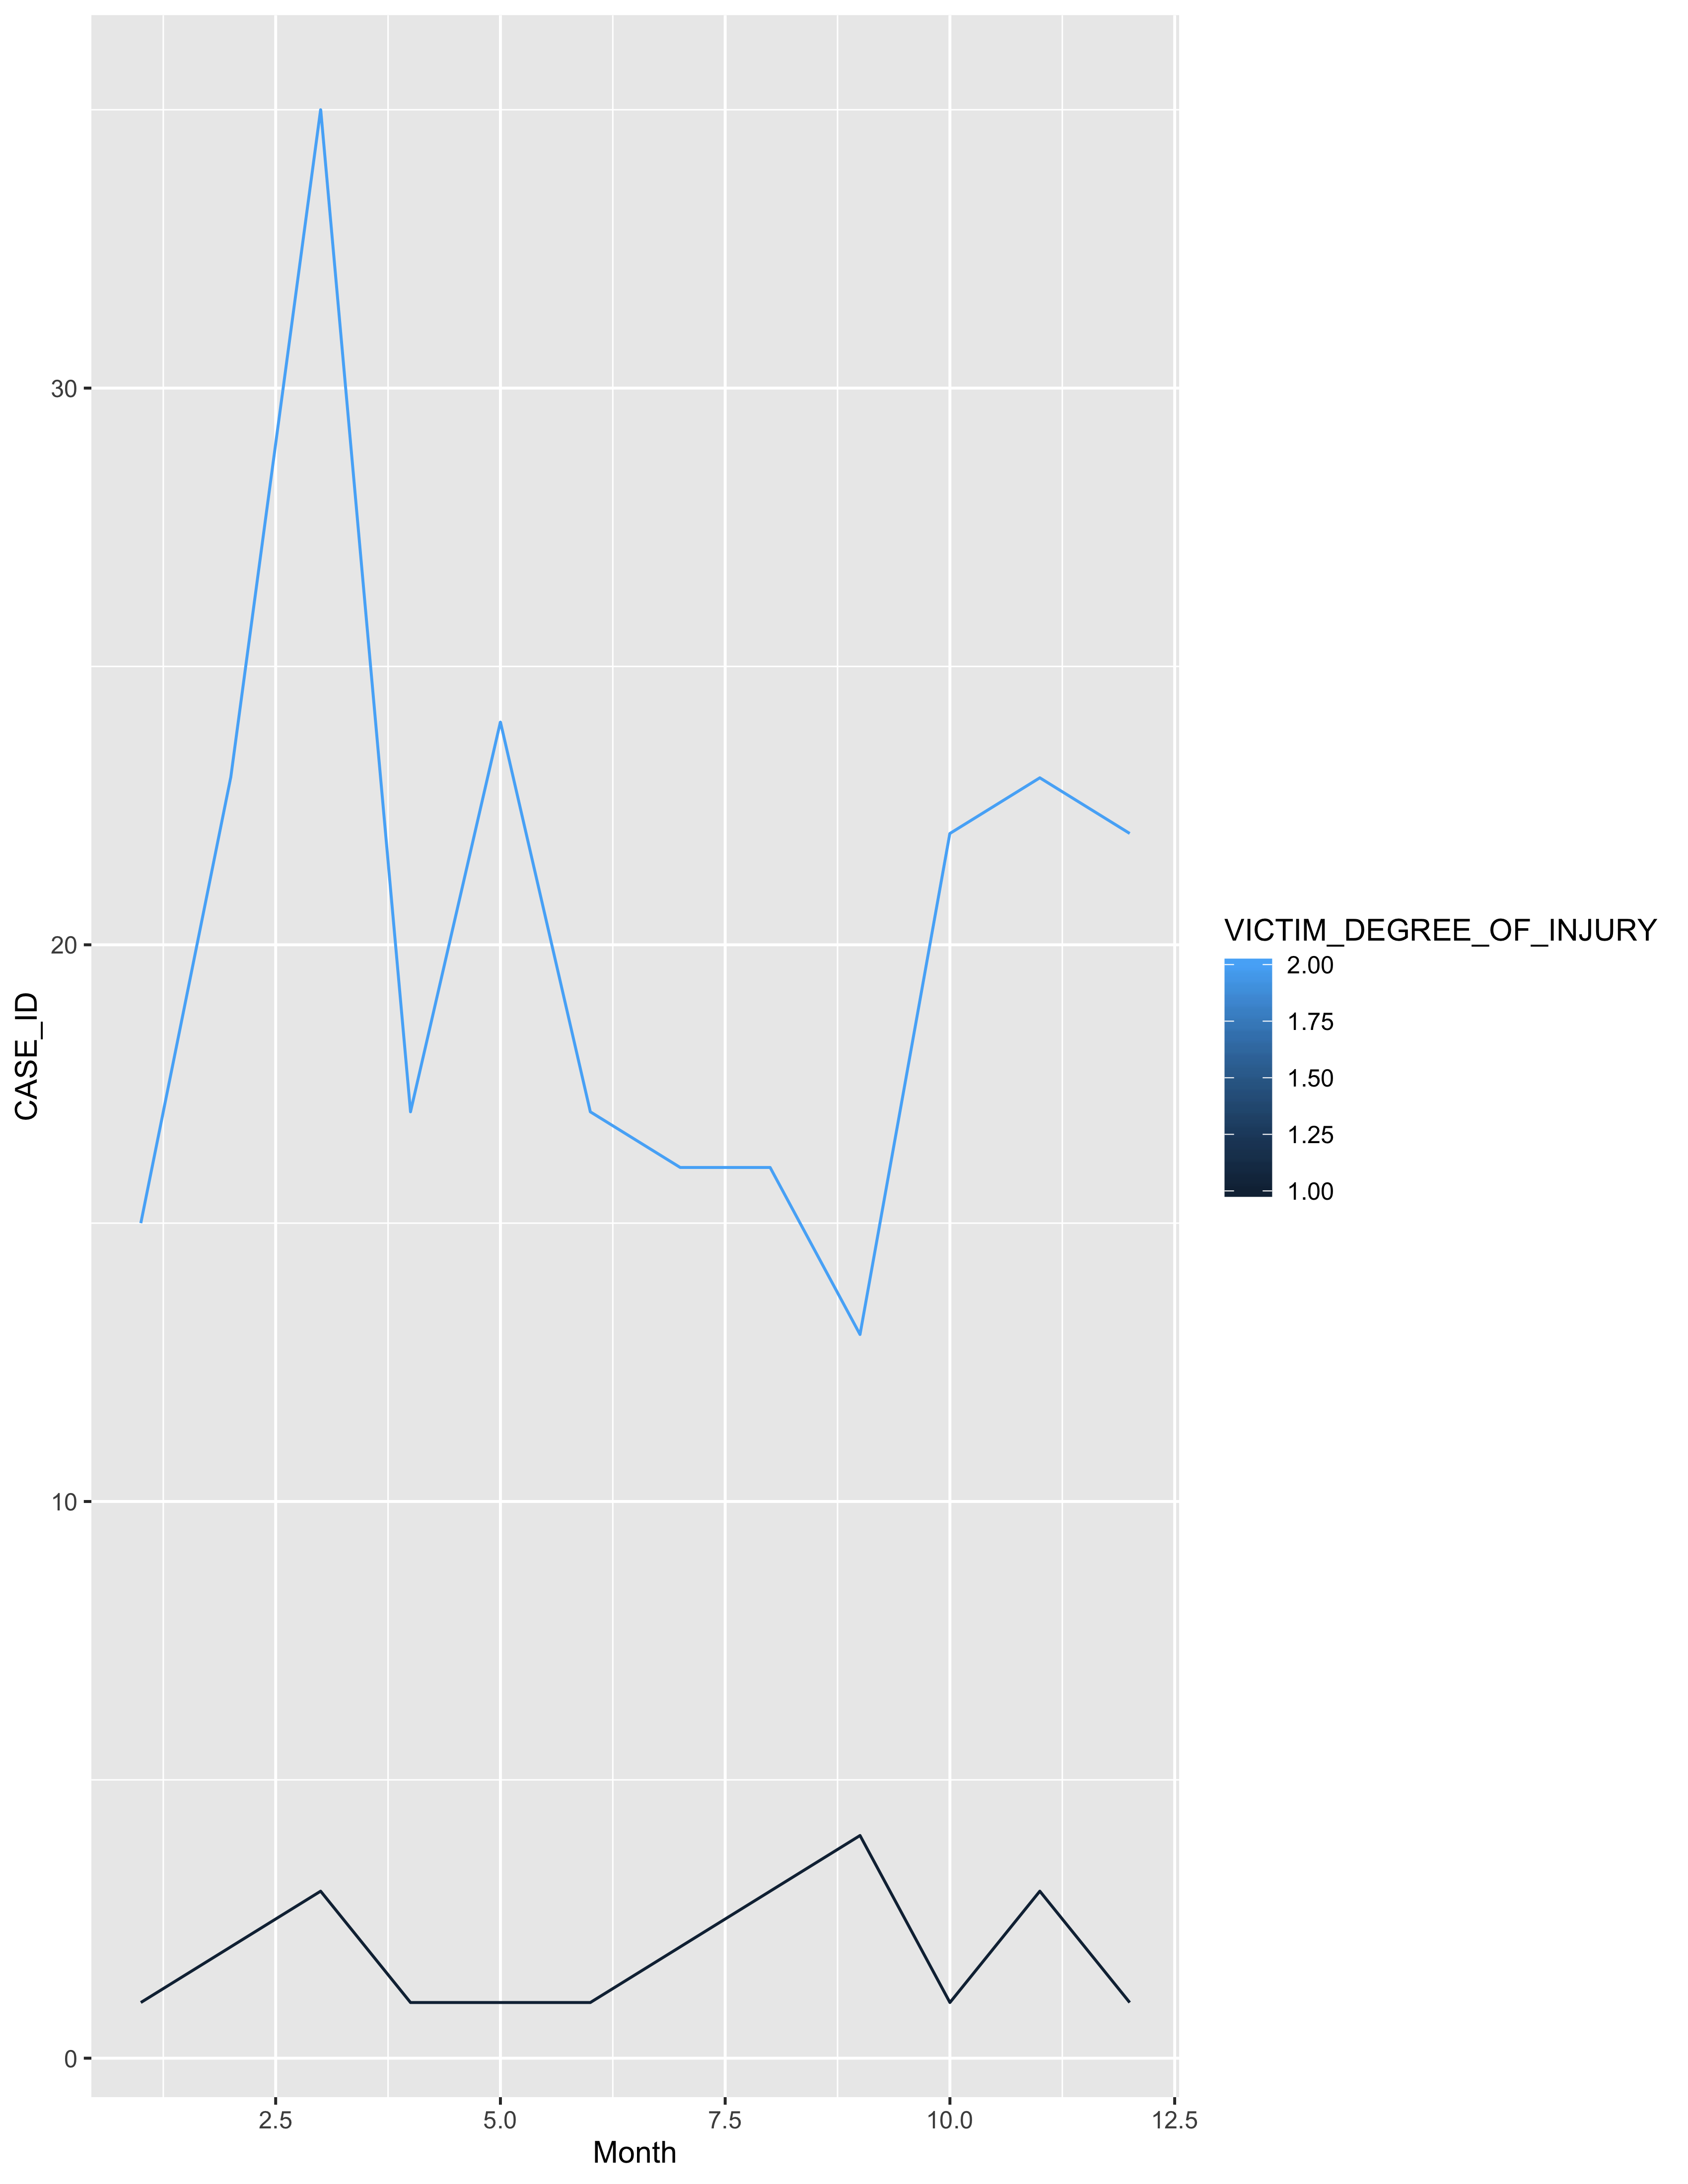

In [21]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_line(aes(x = Month, y = CASE_ID, group = VICTIM_DEGREE_OF_INJURY, color = VICTIM_DEGREE_OF_INJURY), 
          data = cvsmall_m, stat = "identity") 



# Chart 2: Box plot showing spread of speeds by victim degree of injury

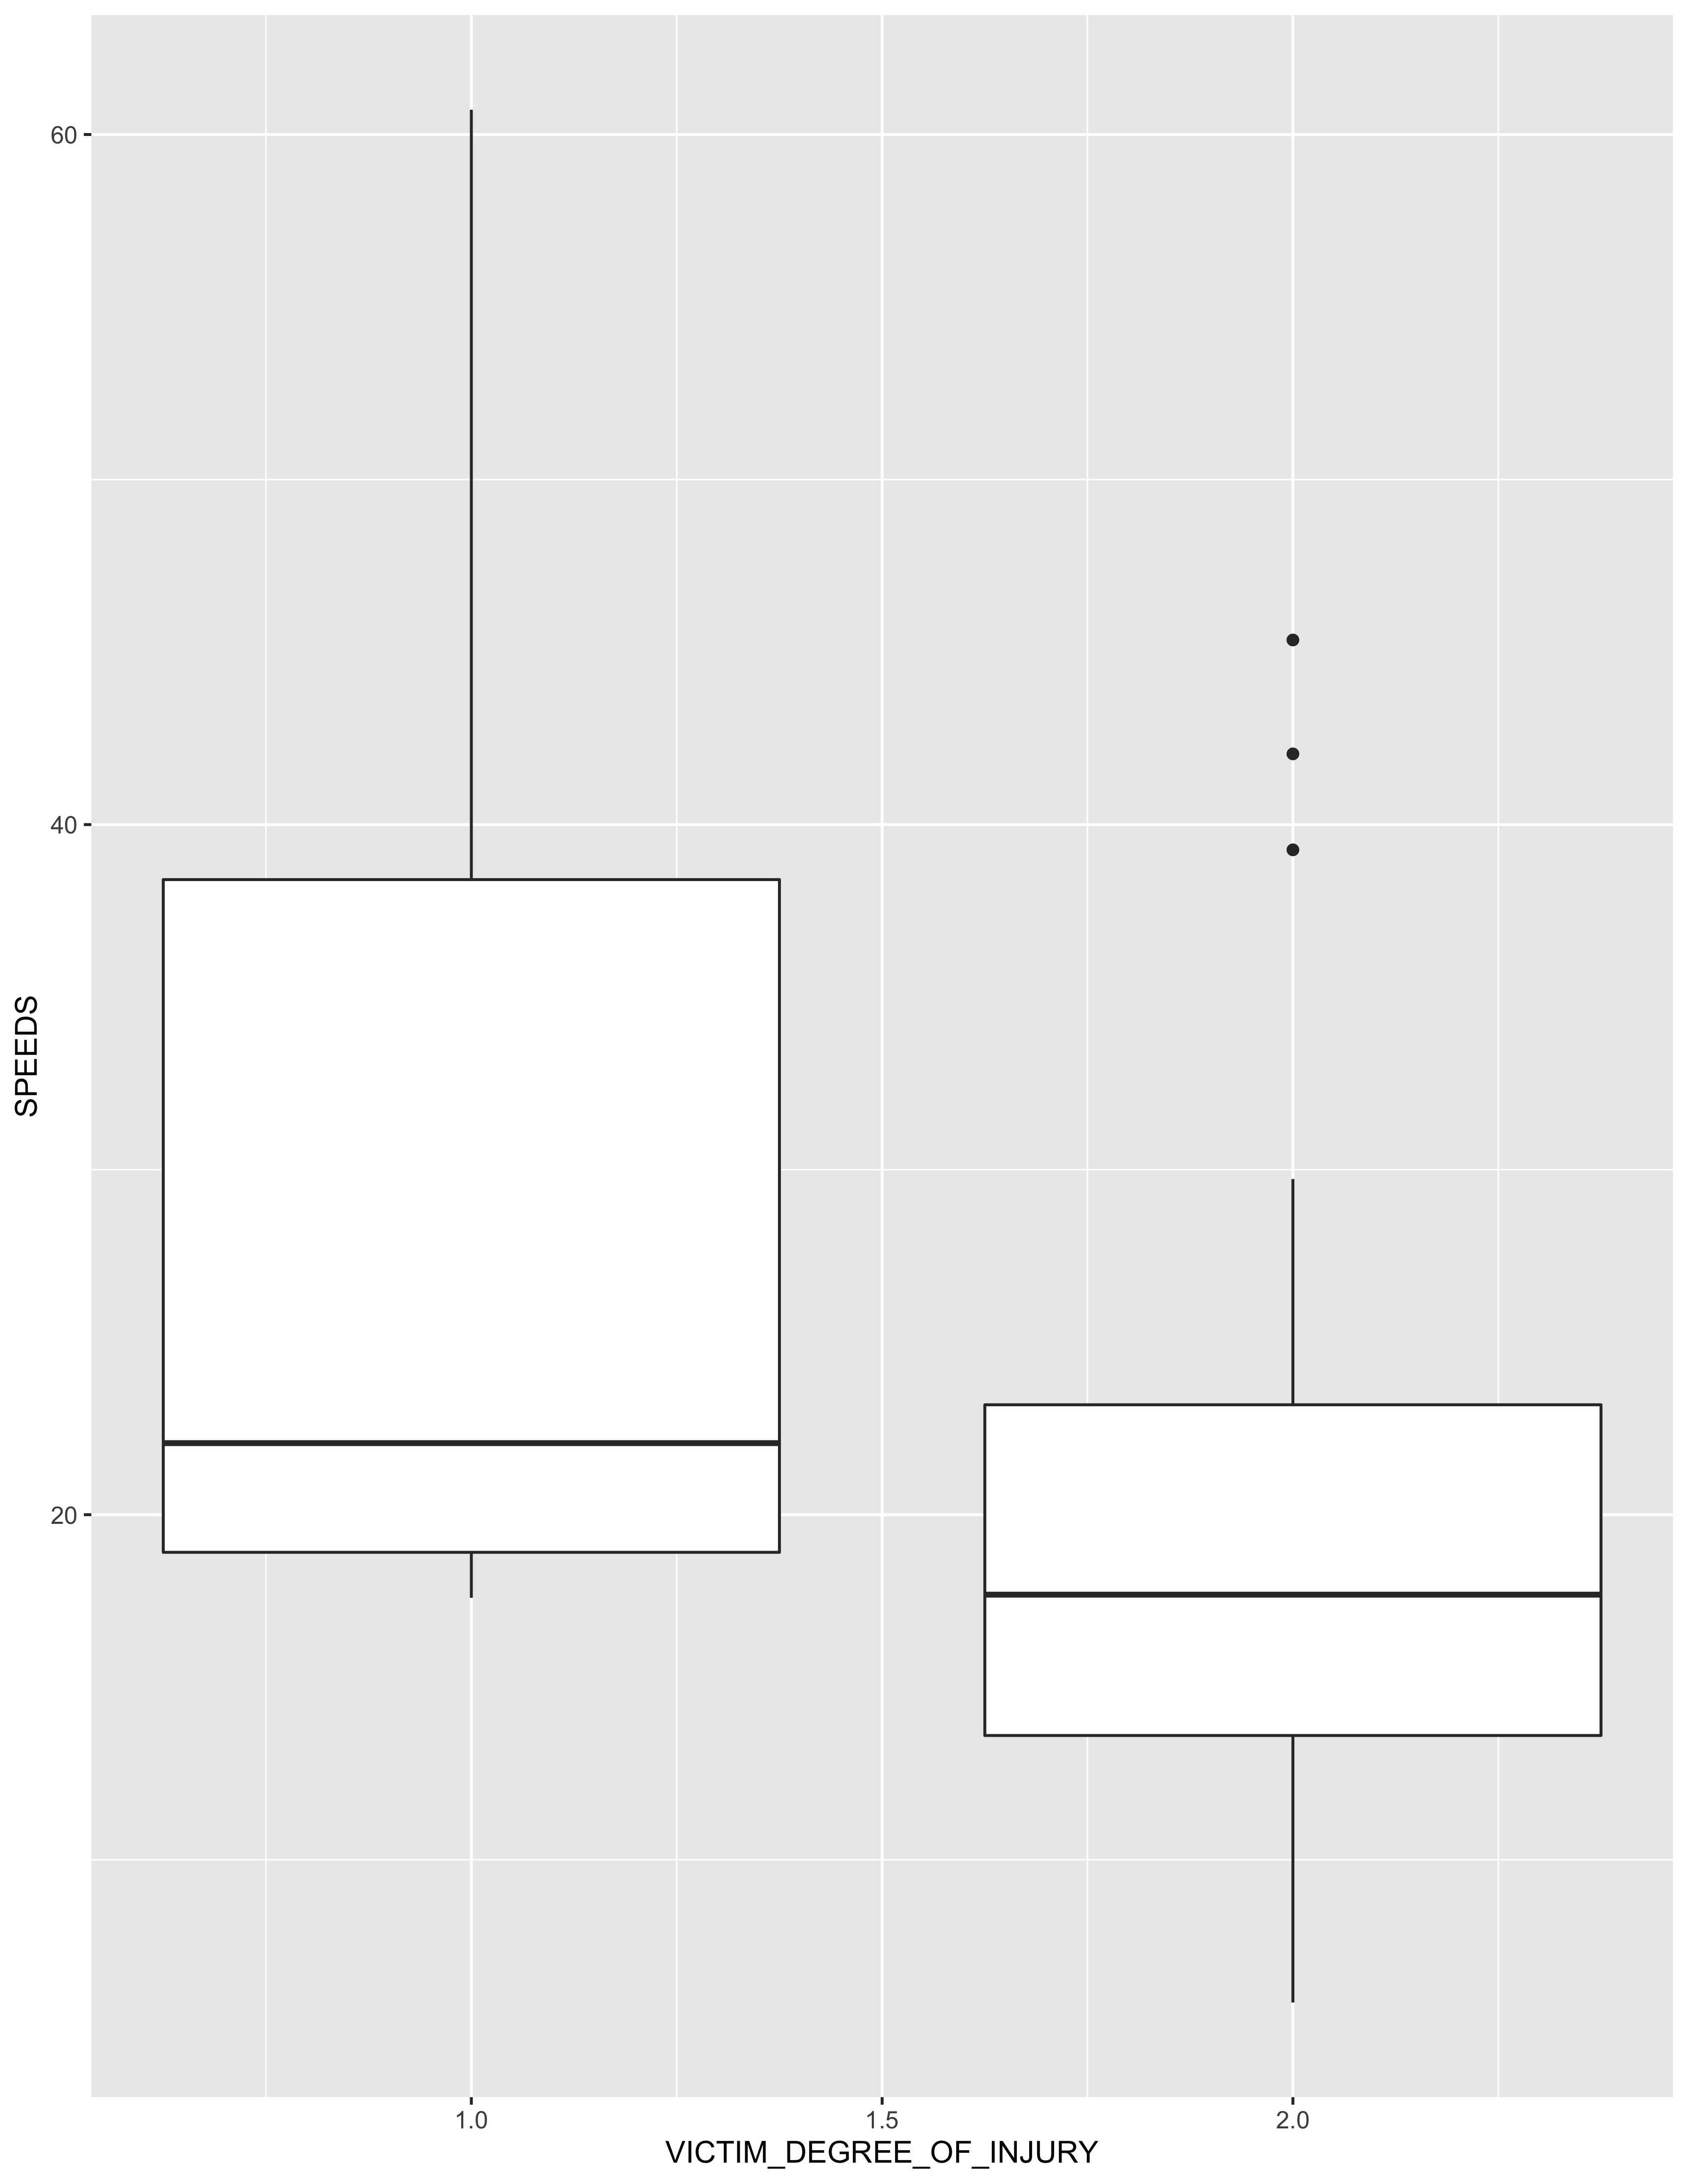

In [22]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
    geom_boxplot(aes(x=VICTIM_DEGREE_OF_INJURY, y=SPEEDS, group = VICTIM_DEGREE_OF_INJURY),data=cvs)

# (Optional) Chart ?: Histogram of ages by victim degree of injury 
(purpose: try to show that as age goes up, fatalities go up (?))

In [23]:
# remove nonsensical/placeholder VICTIM_AGE (=998?)
v_cleanage = v.loc[v.VICTIM_AGE < 150]
v_cleanage = v_cleanage.groupby(["VICTIM_DEGREE_OF_INJURY", "VICTIM_AGE"]).count().reset_index()
v_cleanage.dtypes

VICTIM_DEGREE_OF_INJURY    int64
VICTIM_AGE                 int64
CASE_ID                    int64
VICTIM_ROLE                int64
dtype: object

In [24]:
%R -i v_cleanage

R[write to console]: Warning:
R[write to console]:  Ignoring unknown parameters: binwidth, bins, pad



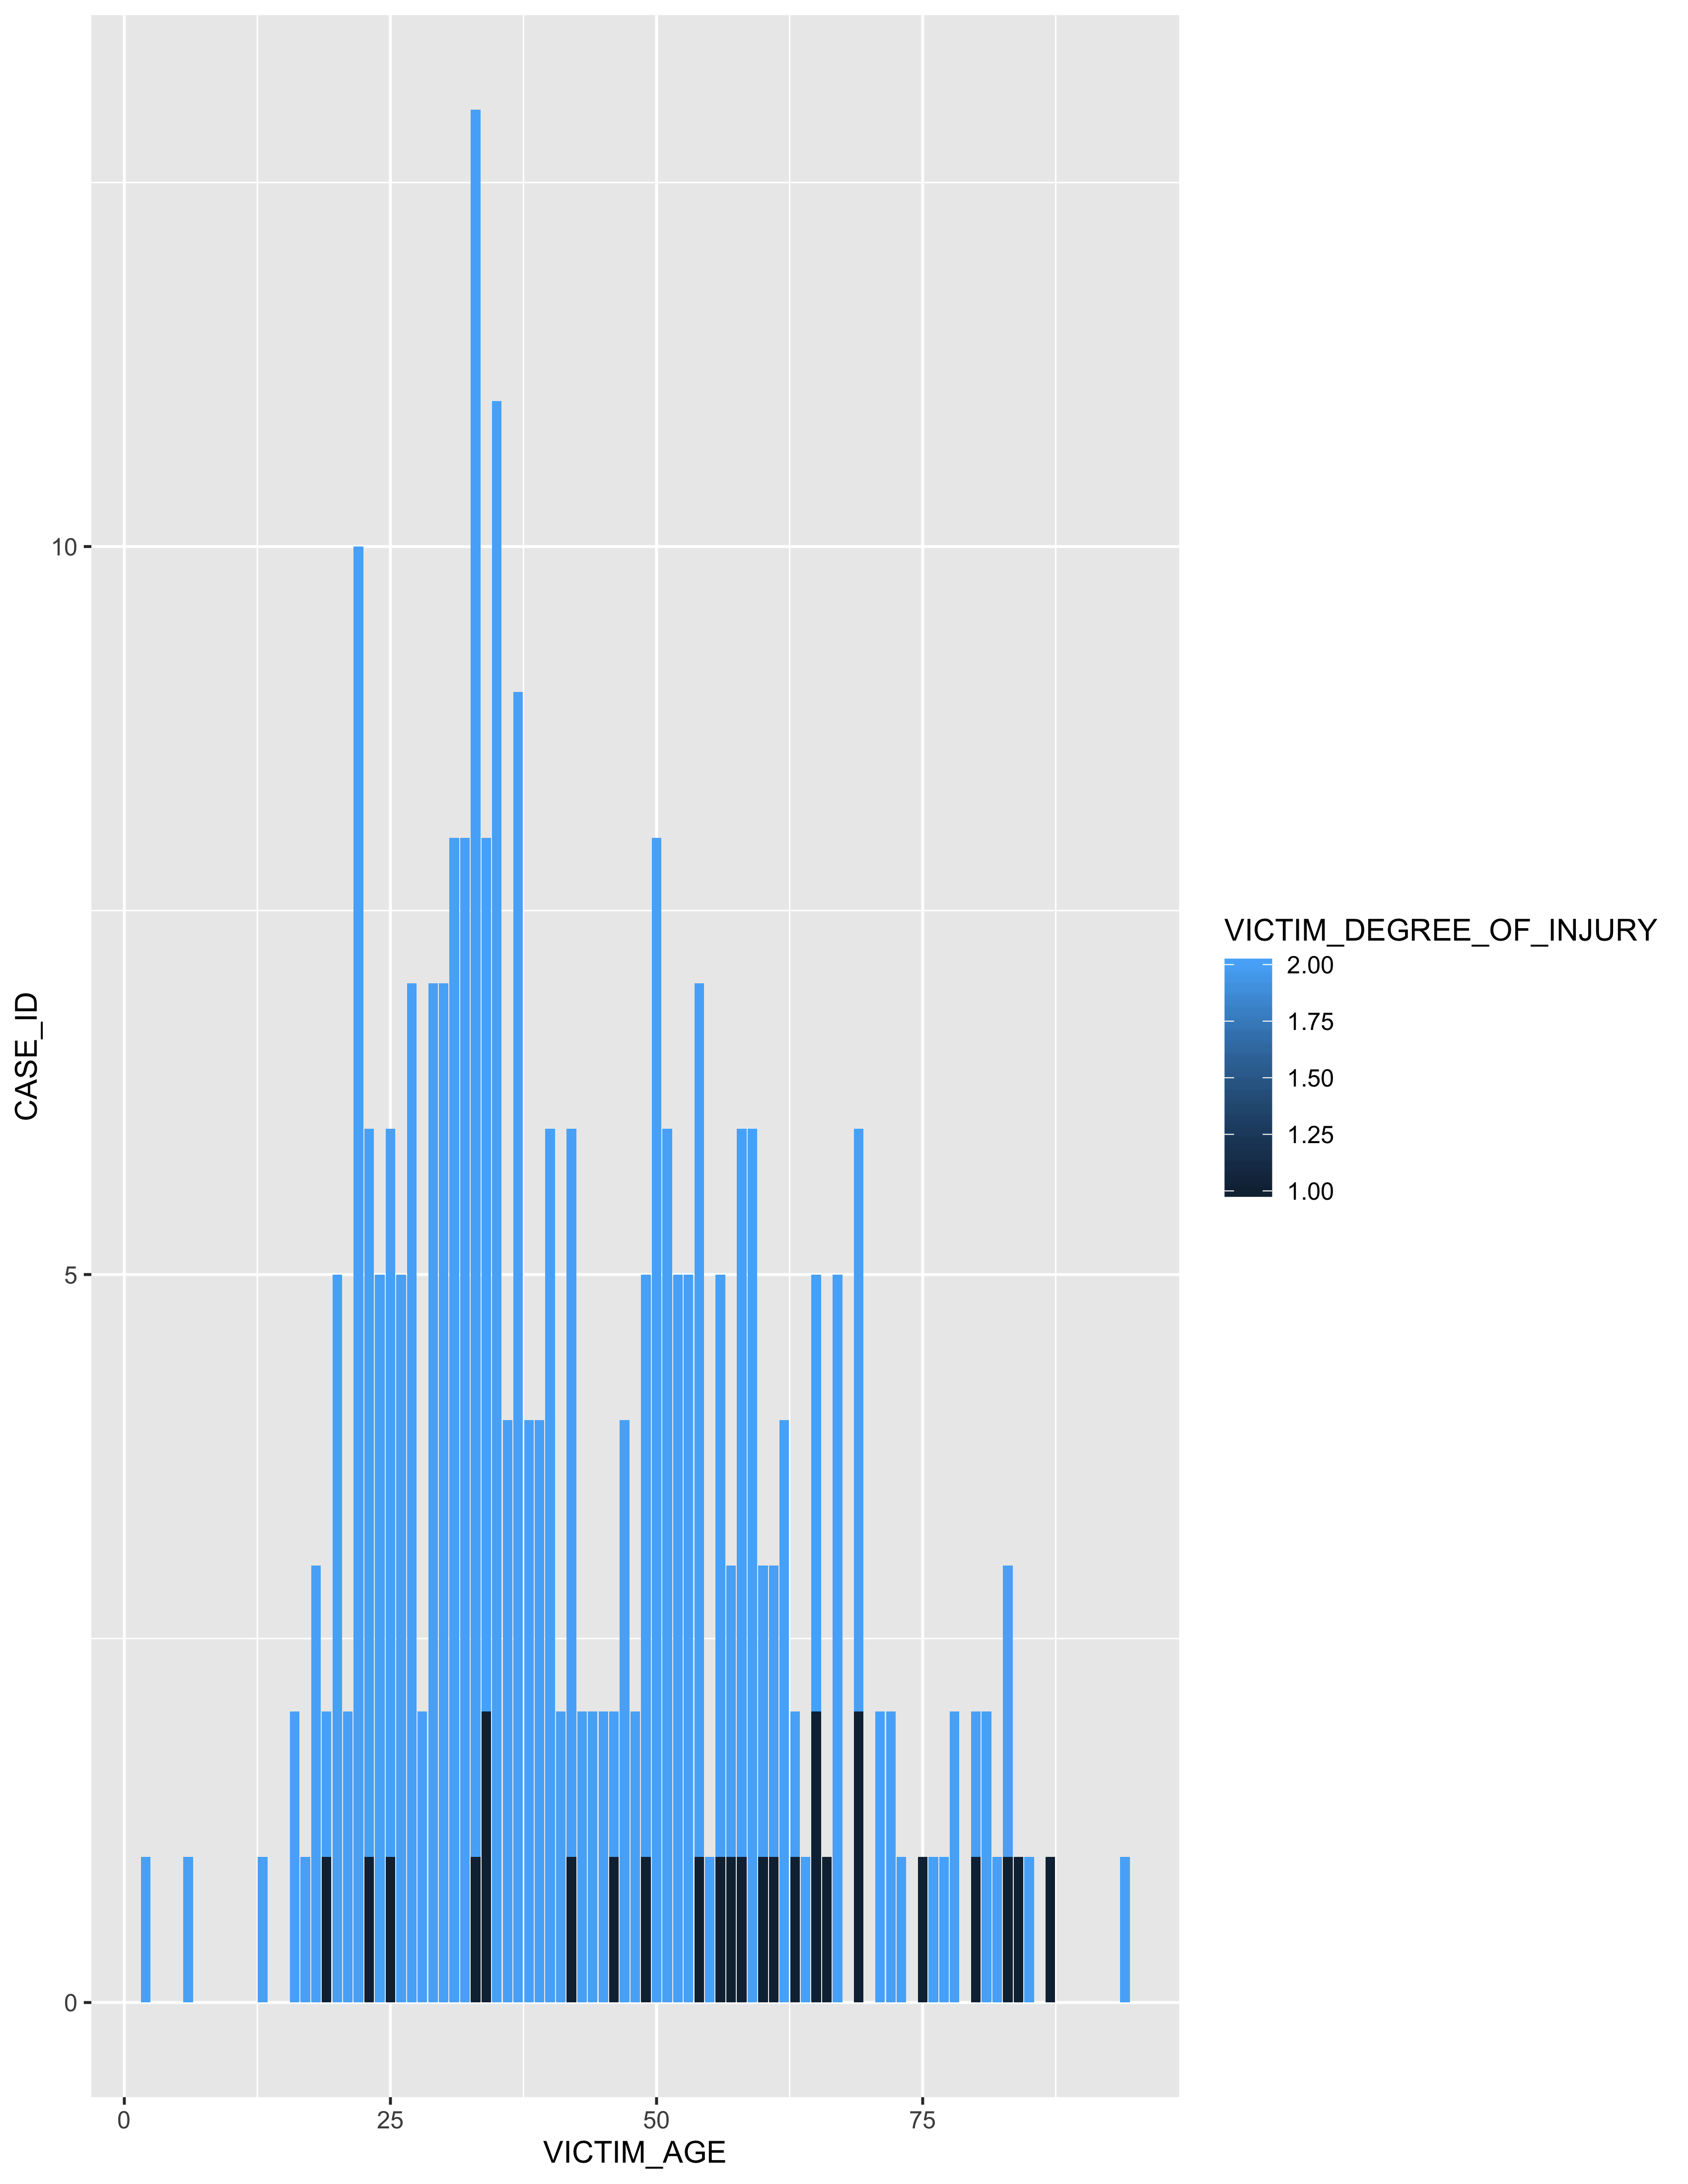

In [25]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() + 
geom_histogram(aes(x = VICTIM_AGE, y = CASE_ID, fill = VICTIM_DEGREE_OF_INJURY), data = v_cleanage, 
               stat = "identity", binwidth = 10)


# Chart 3: Scatterplot of age vs. speed by Victim Degree of Injury

In [26]:
cvs.head()

,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,OSM_ID,SPEEDS,Month
251,8804185,2018-12-29,18,Y,2,C,nan,A,H,nan,...,CLIPPER ST,-122.444840,37.746940,4,2.0,1.0,32.0,148313526,7.753,12
348,8777340,2018-12-01,22,N,2,C,nan,A,H,Y,...,MISSION ST,-122.424334,37.735083,4,2.0,3.0,998.0,27396883,11.451,12
367,8777316,2018-12-02,22,Y,2,C,nan,A,H,nan,...,BOSWORTH ST,-122.426440,37.733670,4,2.0,2.0,29.0,8914988,23.761,12
375,8777306,2018-12-27,13,Y,2,A,nan,A,H,nan,...,INNES AV,-122.379480,37.734140,4,2.0,1.0,23.0,8916919,11.359,12
398,8777283,2018-12-28,16,Y,2,A,nan,A,H,nan,...,JACKSON ST,-122.424680,37.793730,4,2.0,1.0,29.0,224384016,12.138,12


In [27]:
# drop the nonsensical/placeholder ages 
cvs_age = cvs.loc[cvs.VICTIM_AGE < 150]

In [28]:
# group by vic. deg. of inj. to plot mean ("centroid")
cvs_age_ag = cvs.groupby("VICTIM_DEGREE_OF_INJURY").median().reset_index()[["VICTIM_DEGREE_OF_INJURY", "VICTIM_AGE", "SPEEDS"]]
cvs_age_ag

,VICTIM_DEGREE_OF_INJURY,VICTIM_AGE,SPEEDS
0,1.0,60.0,22.0740
1,2.0,37.0,17.6825


In [29]:
%R -i cvs_age
%R -i cvs_age_ag

In [30]:
cvs.VICTIM_DEGREE_OF_INJURY.value_counts()

2.0    94
1.0     7
Name: VICTIM_DEGREE_OF_INJURY, dtype: int64

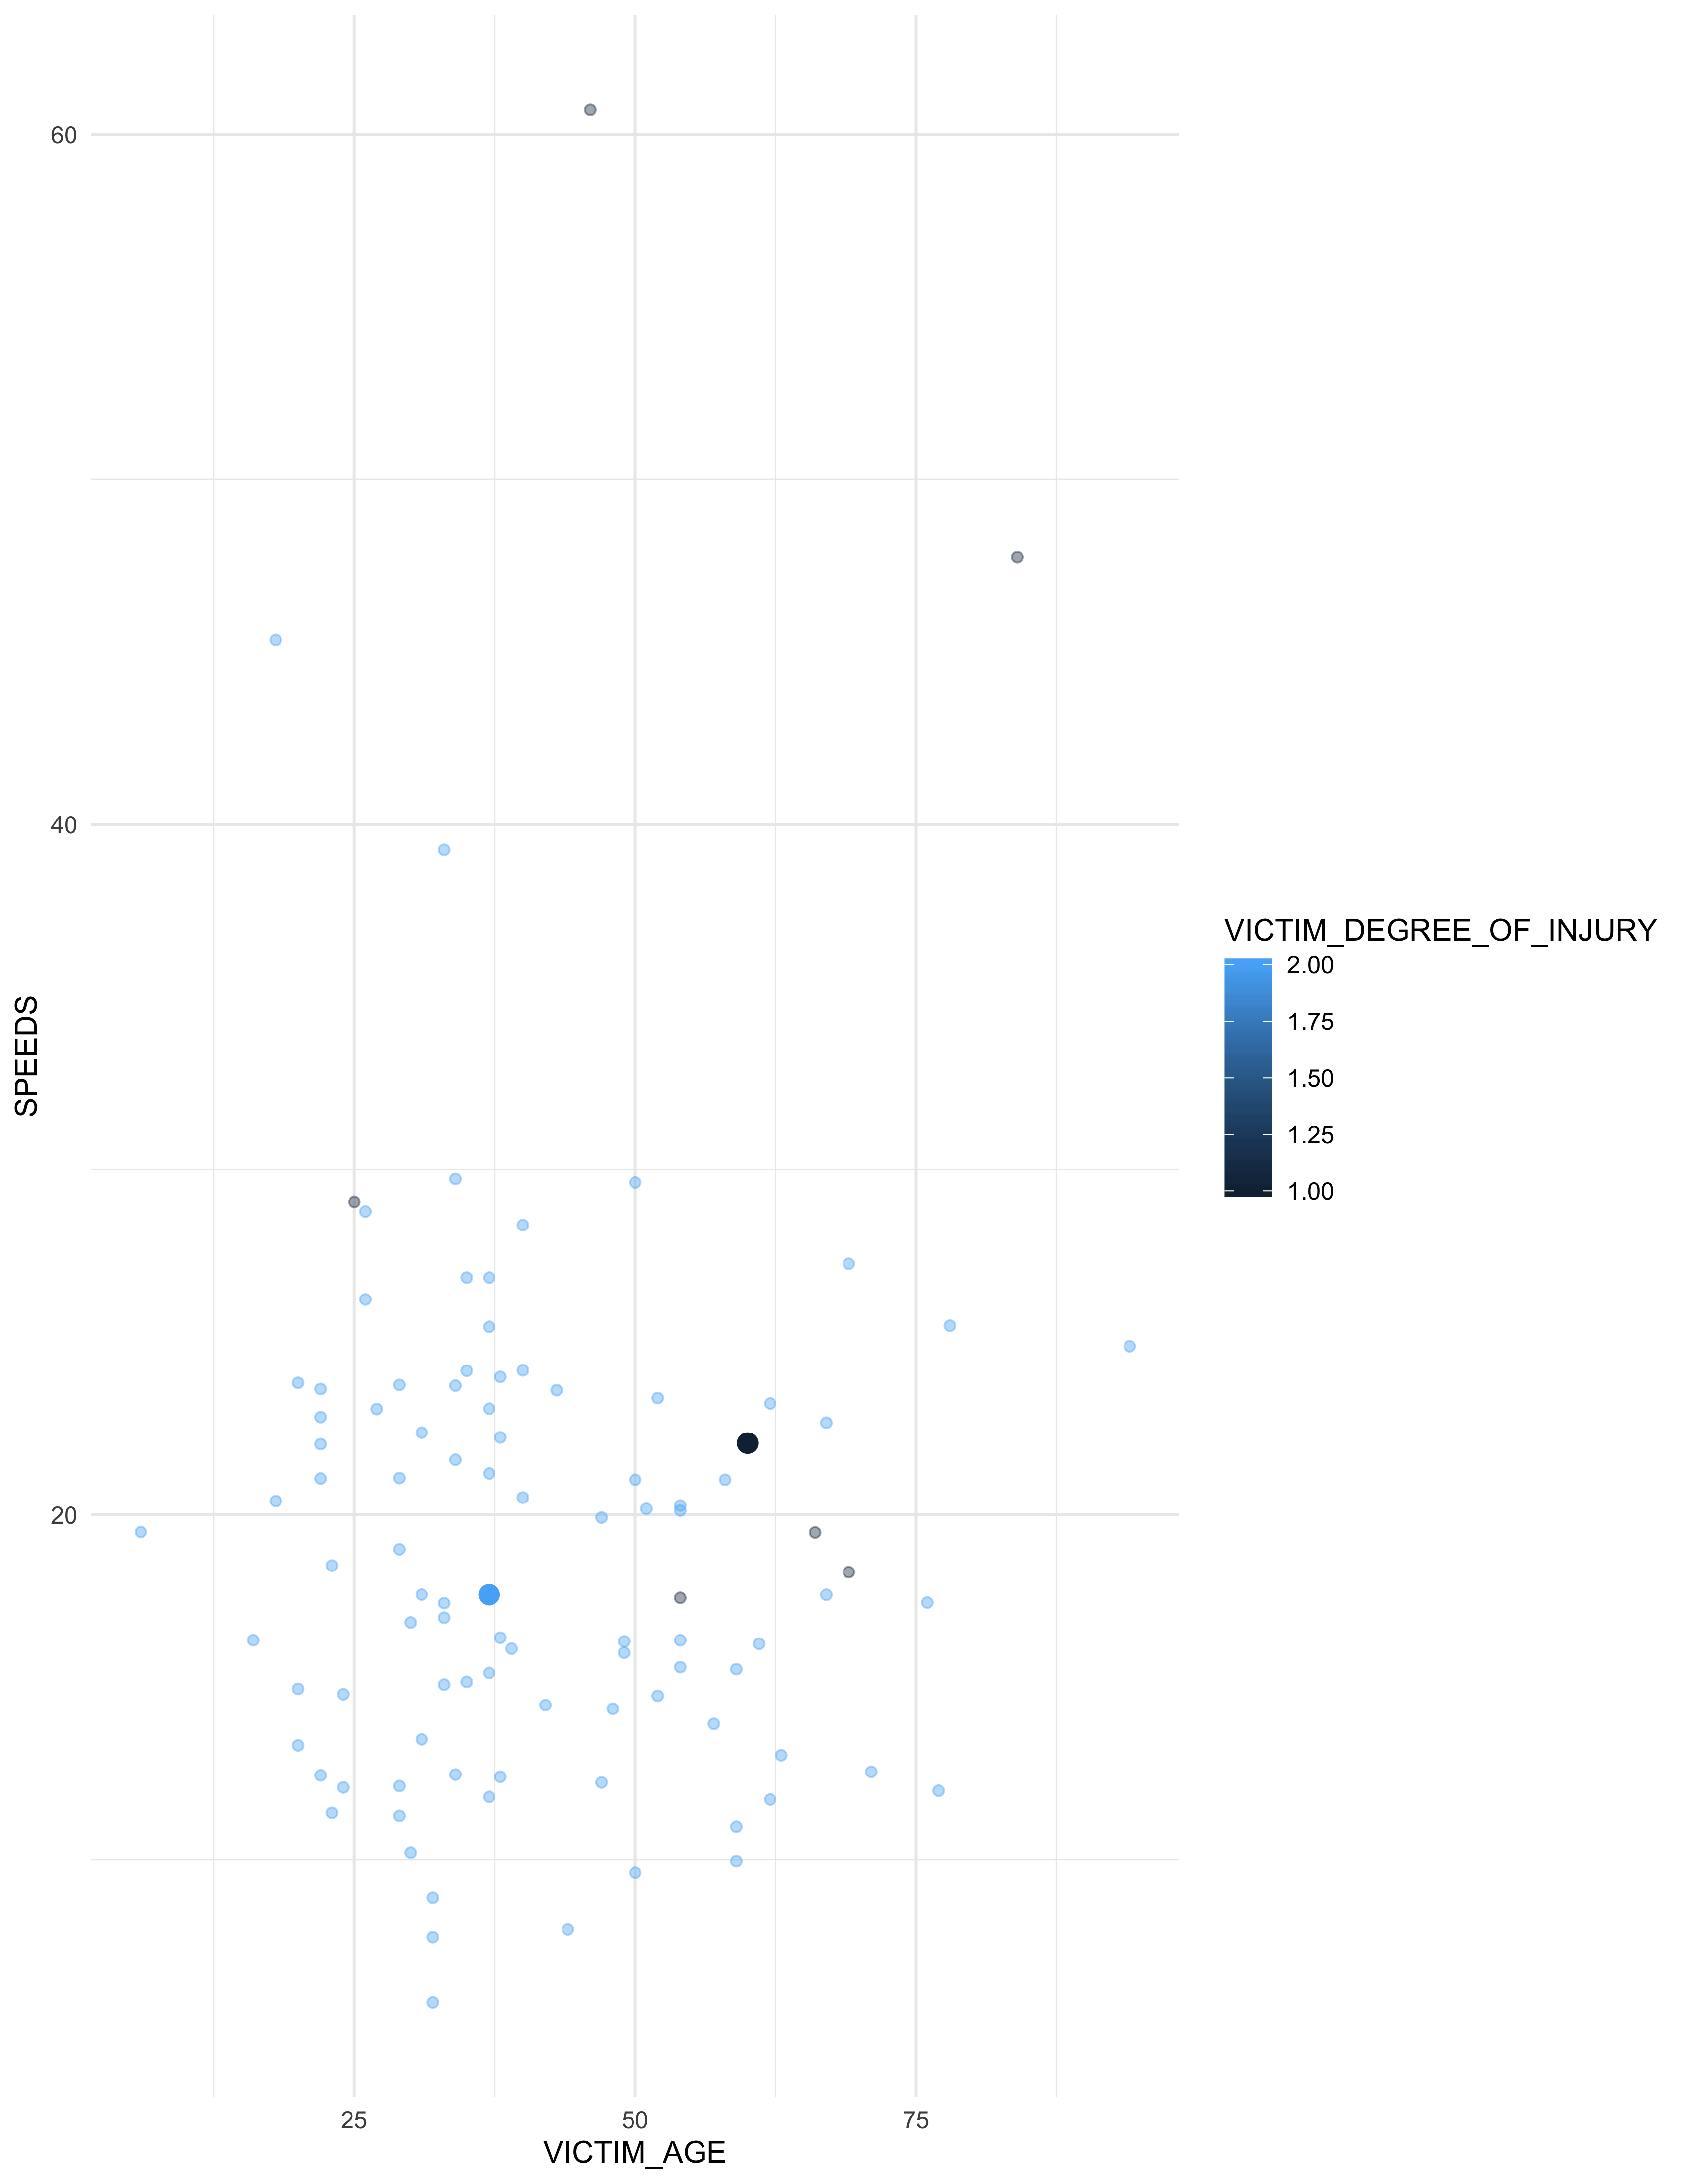

In [31]:
%%R -w 8.5 -h 11 --units in -r 400

ggplot() +
geom_point(aes(x = VICTIM_AGE, y = SPEEDS, color = VICTIM_DEGREE_OF_INJURY), data = cvs_age, alpha = 0.4) +
geom_point(aes(x = VICTIM_AGE, y = SPEEDS, color = VICTIM_DEGREE_OF_INJURY), data = cvs_age_ag, size = 3) +
theme_minimal()

Logistic regression attempt 2, on our variables

In [32]:
# from: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm


from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [33]:
print(cvs.columns)
cvs.head()

Index(['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'INTERSECTION',
       'COLLISION_SEVERITY', 'LIGHTING', 'LOCATION_TYPE', 'ROAD_SURFACE',
       'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT',
       'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'ALCOHOL_INVOLVED', 'LATITUDE',
       'LONGITUDE', 'PRIMARY_RD', 'SECONDARY_RD', 'POINT_X', 'POINT_Y',
       'QUARTER', 'VICTIM_DEGREE_OF_INJURY', 'VICTIM_ROLE', 'VICTIM_AGE',
       'OSM_ID', 'SPEEDS', 'Month'],
      dtype='object')


,CASE_ID,COLLISION_DATE,COLLISION_TIME,INTERSECTION,COLLISION_SEVERITY,LIGHTING,LOCATION_TYPE,ROAD_SURFACE,ROAD_COND_1,PEDESTRIAN_ACCIDENT,...,SECONDARY_RD,POINT_X,POINT_Y,QUARTER,VICTIM_DEGREE_OF_INJURY,VICTIM_ROLE,VICTIM_AGE,OSM_ID,SPEEDS,Month
251,8804185,2018-12-29,18,Y,2,C,nan,A,H,nan,...,CLIPPER ST,-122.444840,37.746940,4,2.0,1.0,32.0,148313526,7.753,12
348,8777340,2018-12-01,22,N,2,C,nan,A,H,Y,...,MISSION ST,-122.424334,37.735083,4,2.0,3.0,998.0,27396883,11.451,12
367,8777316,2018-12-02,22,Y,2,C,nan,A,H,nan,...,BOSWORTH ST,-122.426440,37.733670,4,2.0,2.0,29.0,8914988,23.761,12
375,8777306,2018-12-27,13,Y,2,A,nan,A,H,nan,...,INNES AV,-122.379480,37.734140,4,2.0,1.0,23.0,8916919,11.359,12
398,8777283,2018-12-28,16,Y,2,A,nan,A,H,nan,...,JACKSON ST,-122.424680,37.793730,4,2.0,1.0,29.0,224384016,12.138,12


## 10/2 NOTE: 
I CHANGED THE COLUMNS TO SELECT FOR COLLISIONS (DataFrame c) AT THE VERY TOP/IN THE ORIGINAL CSV PULL!!! This affects the rest of the data from there!!! Rerun for slightly different csv dataset!!!

Predictors: Speeds (con't), Collision_Time (hour of day)(con't), Intersection (dummy), Lighting (categ), Road_Surface (categ), Road_Cond_1 (categ), Pedestrian_Accident (dummy), Bicycle Accident (dummy), Motorcycle Accident (dummy), Truck Accident (dummy), Victim_Age (con't) 

In [61]:
print(cvs.INTERSECTION.value_counts())
print(cvs.LIGHTING.value_counts())
print(cvs.ROAD_SURFACE.value_counts())
print(cvs.ROAD_COND_1.value_counts())

Y    54
N    47
Name: INTERSECTION, dtype: int64
A    56
C    40
B     3
D     2
Name: LIGHTING, dtype: int64
A    86
B    14
-     1
Name: ROAD_SURFACE, dtype: int64
H    98
-     2
D     1
Name: ROAD_COND_1, dtype: int64


In [62]:
# recode variables (as 1s and 0s, reduce categories down, make dummies)

# recoded Collision, Victims, Speeds dataset = cvs_r
cvs_r = cvs.copy()


# NOTE: ROAD_SURFACE and ROAD_COND_1 had some observations unstated
# If not stated, assumed no issues with road surface or con'd

# Intersection: Make dummy, intersection/not
cvs_r.loc[cvs_r.INTERSECTION == "Y", "INTERSECTION"] = 1
cvs_r.loc[cvs_r.INTERSECTION == "N", "INTERSECTION"] = 0
# Lighting: Make 1, 2, 3 for ordinal values for light, dusk/dawn, dark
cvs_r.loc[cvs_r.LIGHTING == "A", "LIGHTING"] = 2  # Light
cvs_r.loc[cvs_r.LIGHTING == "B", "LIGHTING"] = 1  # Dusk/Dawn
cvs_r.loc[cvs_r.LIGHTING.isin(["C", "D", "E"]), "LIGHTING"] = 0  # Dark (w and w/o streetlight)
# Road_Surface: Convert to dummy, wet/not 
cvs_r.loc[cvs_r.ROAD_SURFACE.isin(["B", "C", "D"]), "WET_ROAD_SURFACE"] = 1
cvs_r.loc[~(cvs_r.ROAD_SURFACE.isin(["B", "C", "D"])), "WET_ROAD_SURFACE"] = 0
# Road_Cond_1: Convert to dummy, issue/not
cvs_r.loc[cvs_r.ROAD_COND_1.isin(["H", ""]), "ROAD_COND_ISSUE"] = 0
cvs_r.loc[~(cvs_r.ROAD_COND_1.isin(["H", ""])), "ROAD_COND_ISSUE"] = 1

In [63]:
cvs_r = fixDFcolsForR(cvs_r)

In [64]:
# for dummies: recode Y as 1, blank as 0
def Yfor1(df):
    df = df.replace("Y", 1)
    df = df.replace("nan", 0)
    return df

In [65]:
cvs_r.columns

Index(['CASE_ID', 'COLLISION_DATE', 'COLLISION_TIME', 'INTERSECTION',
       'COLLISION_SEVERITY', 'LIGHTING', 'LOCATION_TYPE', 'ROAD_SURFACE',
       'ROAD_COND_1', 'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT',
       'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT', 'ALCOHOL_INVOLVED', 'LATITUDE',
       'LONGITUDE', 'PRIMARY_RD', 'SECONDARY_RD', 'POINT_X', 'POINT_Y',
       'QUARTER', 'VICTIM_DEGREE_OF_INJURY', 'VICTIM_ROLE', 'VICTIM_AGE',
       'OSM_ID', 'SPEEDS', 'Month', 'WET_ROAD_SURFACE', 'ROAD_COND_ISSUE'],
      dtype='object')

In [66]:
cvs_r["PEDESTRIAN_ACCIDENT"] = Yfor1(cvs_r.PEDESTRIAN_ACCIDENT)
cvs_r["BICYCLE_ACCIDENT"] = Yfor1(cvs_r.BICYCLE_ACCIDENT)
cvs_r["MOTORCYCLE_ACCIDENT"] = Yfor1(cvs_r.MOTORCYCLE_ACCIDENT)
cvs_r["TRUCK_ACCIDENT"] = Yfor1(cvs_r.TRUCK_ACCIDENT)

In [67]:
# need Y values to be 0 or 1 for logistic reg
cvs_r.loc[cvs_r.VICTIM_DEGREE_OF_INJURY == 1, "VDOI_dummy"] = 1
cvs_r.loc[cvs_r.VICTIM_DEGREE_OF_INJURY == 2, "VDOI_dummy"] = 0

In [68]:
# try out multinomial logistic regression

# version of X with all possible predictors
# X = cvs_r[["SPEEDS", "COLLISION_TIME", "INTERSECTION", "LIGHTING", "WET_ROAD_SURFACE", "ROAD_COND_ISSUE", 
#        'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT']]
# X = cvs_r[["INTERSECTION"]]  # works
X = cvs_r[["INTERSECTION"]]
Y = cvs_r["VICTIM_DEGREE_OF_INJURY"]
# split into training and testing data (test = 20% of real obs)
# NOTE: only 7 Y observations, will probably suck
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.20)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

print(y_train.shape)
print(x_train.shape)

80
21
80
21
(80,)
(80, 1)


In [69]:
# fit model
lr = LogisticRegression()
lr.fit(np.asarray(y_train).reshape(-1,1), np.asarray(x_train))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [70]:
print(lr.coef_)
print(lr.intercept_)

[[0.39680623]]
[-0.49208972]


In [71]:
y_pred = lr.predict(x_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [72]:
confusion_matrix(y_test, y_pred)

array([[ 0,  0,  0],
       [ 2,  0,  0],
       [19,  0,  0]])

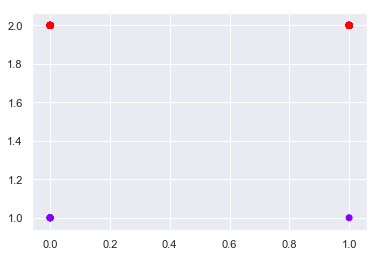

In [73]:
plt.scatter(X, Y, c=Y, cmap='rainbow')

In [74]:
# version of X with all possible predictors
# X = cvs_r[["SPEEDS", "COLLISION_TIME", "INTERSECTION", "LIGHTING", "WET_ROAD_SURFACE", "ROAD_COND_ISSUE", 
#        'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT']]
# X = cvs_r[["INTERSECTION", 'PEDESTRIAN_ACCIDENT']]  # works
X = cvs_r[["INTERSECTION", 'PEDESTRIAN_ACCIDENT']]  # works
Y = cvs_r["VDOI_dummy"]
# split into training and testing data (test = 20% of real obs)
# NOTE: only 7 Y observations, will probably suck
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.20)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

print(y_train.shape)
print(x_train.shape)

80
21
80
21
(80,)
(80, 2)


In [75]:
logit = sm.Logit(y_train, x_train)

# fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.339579
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             VDOI_dummy   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Oct 2019   Pseudo R-squ.:                 -0.4525
Time:                        12:49:42   Log-Likelihood:                -27.166
converged:                       True   LL-Null:                       -18.703
                                        LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
INTERSECTION           -3.4552      1.020     -3.386      0.001      -5.455      -1.455
PE

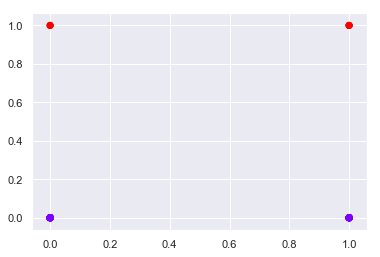

In [76]:
plt.scatter(cvs_r["PEDESTRIAN_ACCIDENT"], Y, c=Y, cmap='rainbow')

In [81]:
# it worked!!!

# try version of X with all possible predictors
# X = cvs_r[["SPEEDS", "COLLISION_TIME", "INTERSECTION", "LIGHTING", "WET_ROAD_SURFACE", "ROAD_COND_ISSUE", 
#            'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT', 'TRUCK_ACCIDENT']]
X = cvs_r[["SPEEDS"]]

Y = cvs_r["VDOI_dummy"]
# split into training and testing data (test = 20% of real obs)
# NOTE: only 7 Y observations, will probably suck
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.20)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

print(x_train.shape)
print(y_train.shape)

print(type(x_train))
print(type(y_train))

print(X.dtypes)
print(Y.dtypes)

80
21
80
21
(80, 1)
(80,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
SPEEDS    float64
dtype: object
float64


In [82]:
logit = sm.Logit(np.array(y_train), np.array(x_train))

# fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.313213
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       79
Method:                           MLE   Df Model:                            0
Date:                Thu, 03 Oct 2019   Pseudo R-squ.:                 -0.3397
Time:                        12:53:31   Log-Likelihood:                -25.057
converged:                       True   LL-Null:                       -18.703
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1275      0.023     -5.478      0.000      -0.173      -0.082


In [83]:
np.e

2.718281828459045

Attempting to solve joins mystery

In [ ]:
len(v.CASE_ID.unique())

In [ ]:
len(c.CASE_ID.unique())

In [ ]:
set_v = set(v.CASE_ID.unique())
set_c = set(c.CASE_ID.unique())

In [ ]:
len(set_c.difference(set_v))

In [ ]:
len(set_v.difference(set_c))  # there are 2 CASE_IDs in V that aren't in C

In [ ]:
len(set_c.intersection(set_v))